In [ ]:
from pathlib import Path
import xarray as xr
import numpy as np
import rasterio

from colormap import svs_tempo_cmap

# get subsetted netcdf files
from glob import glob

In [ ]:
files = glob('nov*/subsetted_netcdf/*.nc')
files = list(files) + list(glob('oct*/subsetted_netcdf/*.nc'))

In [ ]:
import tempo_process_funcs as tpm
import process_data as prd
prd.set_log_level(False)

In [11]:
input_data, datetimes, geospatial_bounds, support = prd.process_files(files, 'svs', False)

Reading in data: 100%|██████████| 774/774 [01:22<00:00,  9.34it/s]


In [ ]:
final_data = xr.combine_by_coords(input_data)
_ = final_data.rio.write_crs("epsg:4326", inplace=True)
final_data['vertical_column_troposphere'].name = 'NO2'
new_data = final_data['vertical_column_troposphere']
new_data = new_data.rio.write_nodata(np.nan, encoded=True)
no2_norm = 10**14
new_data.data = new_data.data/no2_norm # normal range will be from 1 to 150

In [13]:
new_data

<xarray.DataArray 'vertical_column_troposphere' (time: 765, latitude: 2950,
                                                 longitude: 7750)>
dask.array<truediv, shape=(765, 2950, 7750), dtype=float64, chunksize=(1, 2526, 6640), chunktype=numpy.ndarray>
Coordinates:
  * longitude    (longitude) float32 -168.0 -168.0 -167.9 ... -13.03 -13.01
  * latitude     (latitude) float32 14.01 14.03 14.05 ... 72.95 72.97 72.99
  * time         (time) datetime64[ns] 2024-09-30T11:28:18.137864960 ... 2024...
    spatial_ref  int64 0
Attributes:
    coordinates:  time longitude latitude
    long_name:    troposphere nitrogen dioxide vertical column
    units:        molecules/cm^2

In [ ]:
print(f"Time range: {new_data.time.values.min()} to {new_data.time.values.max()}")

In [ ]:
sorted = new_data.sortby('time')
(sorted['time'].values == new_data['time'].values).all()

print("Rechunking data")
# rechunk = new_data.chunk(chunks={"longitude":188, "latitude":373, "time":1})
rechunk = new_data.chunk({"time": -1, "longitude":188, "latitude":373})


Rechunking data


In [ ]:
# We want to make a bunch of average layers
# - Daily Averages
# - Weekly Average
# - Weekday Average
# - Weekend Average
# - Monthly Average
# - Hourly Average (so same hour of each day)
daily_avg = new_data.resample(time='1D').mean()
weekly_avg = new_data.resample(time='1W').mean()
 # Averages all the weekdays, so average monday, tuesday, etc
weekday_avg = new_data.groupby('time.weekday').mean(dim='time')
monthly_avg = new_data.resample(time='1M').mean()
hourly_avg = new_data.groupby(new_data['time.hour']).mean()

In [ ]:
# Define uniform chunk sizes
chunk_sizes = {"time": 1, "longitude":188, "latitude":373}
chunks_spatial = {"longitude":188, "latitude":373}

# Rechunk averages
daily_avg = daily_avg.chunk(chunk_sizes)
weekly_avg = weekly_avg.chunk(chunk_sizes)
weekday_avg = weekday_avg.chunk(chunks_spatial)
monthly_avg = monthly_avg.chunk(chunks_spatial)
hourly_avg = hourly_avg.chunk( {"hour": 1, "longitude":188, "latitude":373})

In [ ]:
a = daily_avg[0].to_numpy() # takes 30 seconds

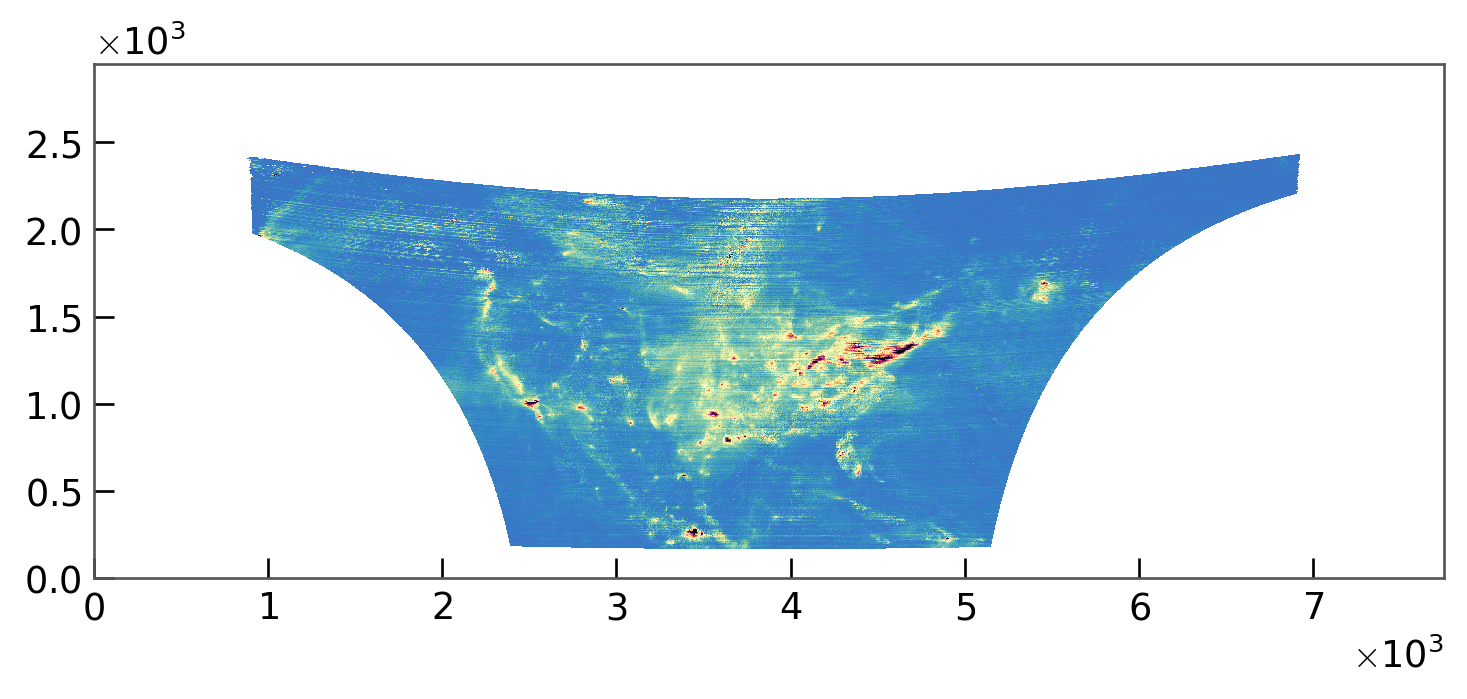

In [48]:
plt.imshow(a, cmap=svs_tempo_cmap, vmin=0.01, vmax = 1.5)

In [ ]:

# Save averages to Zarr files
daily_avg.to_zarr('aggregated/daily_avg.zarr')
weekly_avg.to_zarr('aggregated/weekly_avg.zarr')
weekday_avg.to_zarr('aggregated/weekday_avg.zarr')
weekend_avg.to_zarr('aggregated/weekend_avg.zarr')
monthly_avg.to_zarr('aggregated/monthly_avg.zarr')
hourly_avg.to_zarr('aggregated/hourly_avg.zarr')

In [ ]:
# Save averages to NetCDF files
daily_avg.to_netcdf('aggregated/daily_avg.nc')
weekly_avg.to_netcdf('aggregated/weekly_avg.nc')
weekday_avg.to_netcdf('aggregated/weekday_avg.nc')
weekend_avg.to_netcdf('aggregated/weekend_avg.nc')
monthly_avg.to_netcdf('aggregated/monthly_avg.nc')
hourly_avg.to_netcdf('aggregated/hourly_avg.nc')

In [39]:
bounds = get_bounds(mean_data)
plot_image(xarray = mean_data, 
           bounds = bounds, 
           cmap=svs_tempo_cmap, 
           vmin=0,
           vmax=1.5,
           filename='july_mean_no2.png')


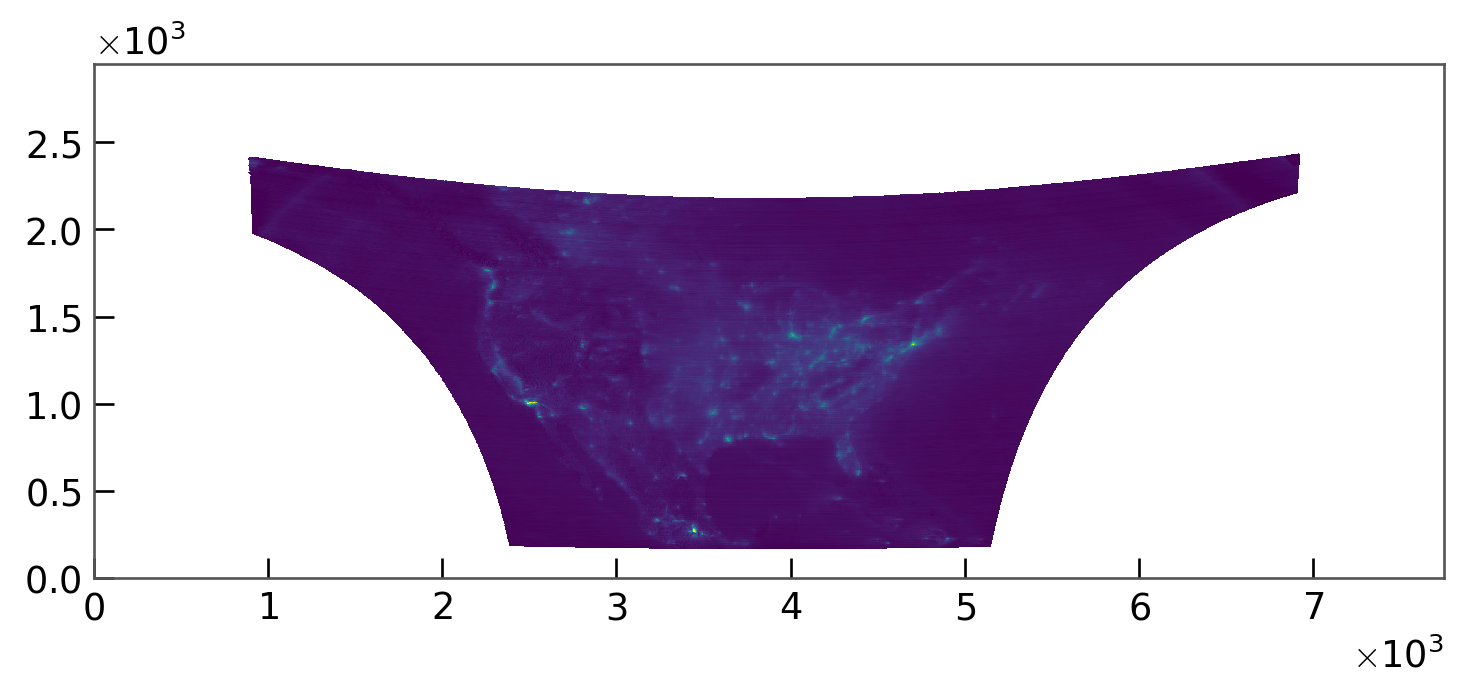

In [38]:
plt.imshow(mean_data.to_numpy(),vmin=0,vmax=1.5)

In [27]:
mean_ma = mean.to_masked_array()

In [29]:
mean_ma.shape

(2950, 7750)

In [66]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.image as mimg


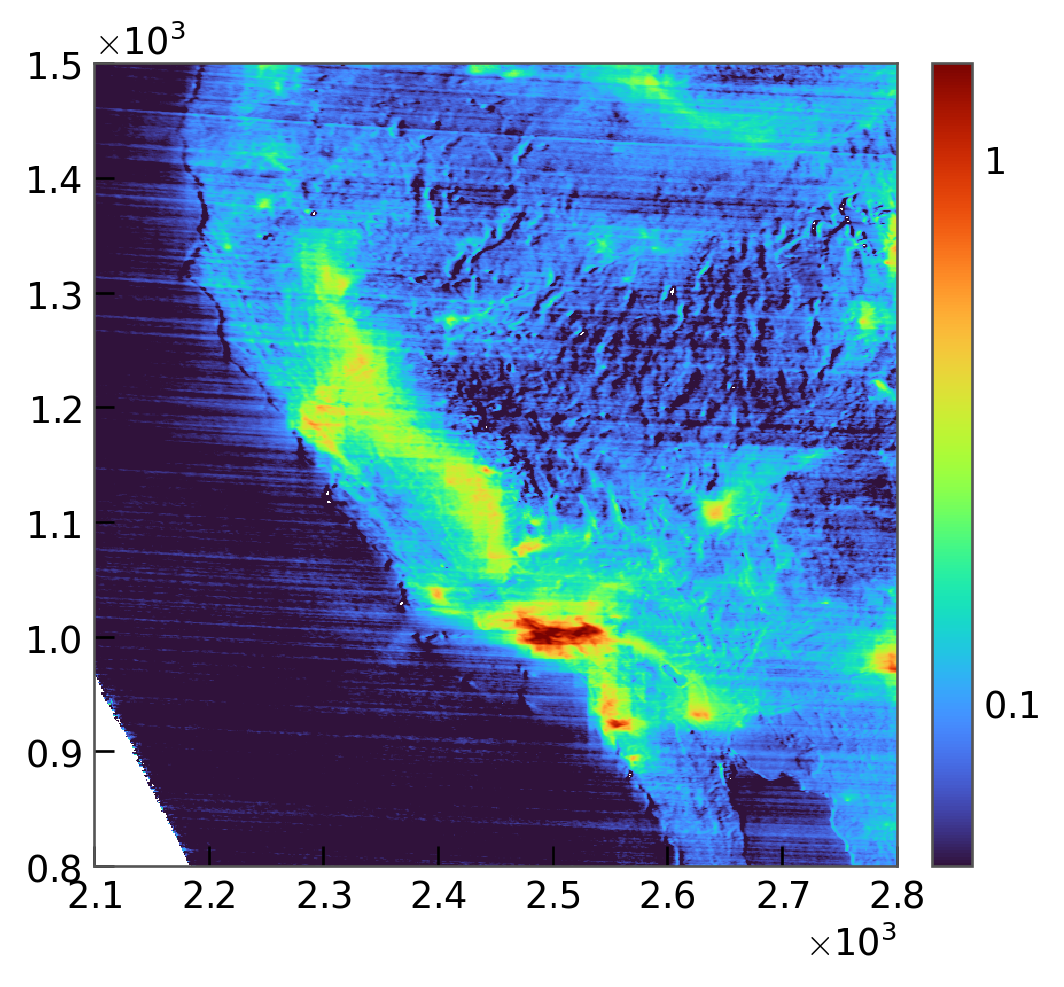

In [65]:
plt.imshow(mean_ma, cmap='turbo', norm = mcolors.LogNorm(vmin=0.05, vmax=1.5))
plt.xlim(2100,2800)
plt.ylim(800,1500)
# add colorbar
plt.colorbar(fraction=0.05, pad=0.005)

In [70]:
# do the same but using mimg.imsave
mimg.imsave('july_mean_no2_b.png', mcolors.LogNorm(vmin=0.05, vmax=1.5)(mean_ma), cmap='turbo',vmin=0,vmax=1)

In [71]:
# save the mean_data
mean_data.to_netcdf('july_mean_no2.nc')